In [1]:
#export 
suppressMessages(source("exp/nb_04.R"))

Warning message:
“package ‘survival’ was built under R version 4.1.1”


In [3]:
#export
library(mboost)

## Load data

### Random data

In [4]:
dfs = readRDS(paste(data_path,"dfs_random.rds", sep=""))
length(dfs)

[1] 8

## Meta-Learner

In [5]:
#export
learning_algs =   c("Cox_PH_model",
                    "Ridge",
                    "Elastic_Net",
                    "Lasso",
                    "Gradient_Boosting_tree_based",
                    "Gradient_Boosting_linear_model_based",
                    "Random_Survival_Forests",
                    "Maximally_selected_rank_statistics_Random_Forests",
                    "Survival_Tree"
                   )

In [6]:
#export
learners = list(makeLearner("surv.coxph",           id = learning_algs[[1]]),
                makeLearner("surv.cvglmnet",        id = learning_algs[[2]], alpha = 0,   nfolds=5),
                makeLearner("surv.cvglmnet",        id = learning_algs[[3]], alpha = 0.5, nfolds=5),
                makeLearner("surv.cvglmnet",        id = learning_algs[[4]], alpha = 1,   nfolds=5),
                makeLearner("surv.gamboost",        id = learning_algs[[5]], baselearner = "bols" ),
                makeLearner("surv.gamboost",        id = learning_algs[[6]], baselearner = "btree"),
                makeLearner("surv.randomForestSRC", id = learning_algs[[7]]),
                makeLearner("surv.ranger",          id = learning_algs[[8]]),
                makeLearner("surv.rpart",           id = learning_algs[[9]])
               )
names(learners) = learning_algs

In [27]:
#export
MetaLearner = function(df, learners){
    list(
    task              = makeSurvTask(data = df, target = c("survival_time", "event")),
    resampler         = makeResampleDesc("CV", iters = 5),
    
    train_models      = purrr::partial(mlr::train, task = task),
    resample_learners = purrr::partial(mlr::resample, task = task, resampling = resampler, show.info = FALSE),
    
    #models           = map(learners, train_models)
#     resamplers        = map(learners, resample_learners() )
    resamplers        = map(learners, purrr::partial(mlr::resample, 
                                                     task = task, 
                                                     resampling = resampler, 
                                                     show.info = FALSE) )
    )
}

In [28]:
#export
MetaLearner = purrr::partial(MetaLearner, learners = learners)

In [29]:
#export
get_c_index = function(resampler){resampler$aggr[[1]]}

In [30]:
#export
get_c_index_for_algs = function(resampler){
    l = map(resampler, get_c_index)
    df = data.frame(matrix(unlist(l), ncol=length(l), byrow=FALSE),stringsAsFactors=FALSE)
    names(df) = names(l)
    df
}

### TMP

In [31]:
ml_cv = map(dfs[[8]], MetaLearner)

ERROR: Error in checkClass(x, classes, ordered, null.ok): object 'task' not found


### RUN

In [395]:
metalearners_nki = map(dfs[[6]], MetaLearner)

In [396]:
#saveRDS(metalearners_nki, paste(data_path,"metalearners_random_",names(dfs)[[6]],".rds", sep=""))

In [262]:
dfs_signatures =         readRDS(paste(data_path,"dfs_signatures.rds"))
dfs_feature_selections = readRDS(paste(data_path,"dfs_feature_selections.rds"))
dfs_npi                = readRDS(paste(data_path,"dfs_npi.rds"))

In [263]:
for (i in 1:7){
    print(i)
    ML = map(dfs[[i]], MetaLearner)
    saveRDS(ML, paste(data_path,"metalearners_random_",names(dfs)[[i]],".rds", sep=""))
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


ERROR: Error in (function (cn, x) : Column 'FGD1' contains NaN values.


In [265]:
i = 8
ML = map(dfs[[i]], MetaLearner)
saveRDS(ML, paste(data_path,"metalearners_random_",names(dfs)[[i]],".rds", sep=""))

In [264]:
for (i in 1:8){
    print(i)
    ML = map(dfs_signatures[[i]], MetaLearner)
    saveRDS(ML, paste(data_path,"metalearners_signatures_",names(dfs)[[i]],".rds", sep=""))
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


ERROR: Error in (function (cn, x) : Column 'VPREB1' contains NaN values.


In [398]:
dfs_signatures[[6]] = map(dfs_signatures[[6]], complete_df)

In [400]:
i = 6
ML = map(dfs_signatures[[i]], MetaLearner)
saveRDS(ML, paste(data_path,"metalearners_signatures_",names(dfs)[[i]],".rds", sep=""))

In [266]:
i = 8
ML = map(dfs_signatures[[i]], MetaLearner)
saveRDS(ML, paste(data_path,"metalearners_signatures_",names(dfs)[[i]],".rds", sep=""))

In [267]:
for (i in c(1,2,3,4,5,6,8)){
    print(i)
    ML = map(dfs_feature_selections[[i]], MetaLearner)
    saveRDS(ML, paste(data_path,"metalearners_feature_selections_",names(dfs)[[i]],".rds", sep=""))
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 8


In [279]:
for (i in c(1,2,3,4,5,6,8)){
    print(i)
    df = dfs_npi[[i]]
    ML = MetaLearner(df)
    saveRDS(ML, paste(data_path,"metalearners_npi_",names(dfs)[[i]],".rds", sep=""))
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6


ERROR: Error in makeSurvTask(data = df, target = c("survival_time", "event")): Assertion on 'target column time' failed: Contains missing values (element 175).


In [299]:
i = 8
df = dfs_npi[[i]]
df = subset(df, is.na(df$survival_time)==FALSE)
ML = MetaLearner(df)
saveRDS(ML, paste(data_path,"metalearners_npi_",names(dfs)[[i]],".rds", sep=""))

### i = 7

In [384]:
#export
complete_df = function(df){df[complete.cases(df), ]}

In [322]:
i = 7
df_rand = dfs[[i]]
df_sign = dfs_signatures[[i]]       
df_feat = dfs_feature_selections[[i]]
df_npi  = list(dfs_npi[[i]])               

In [317]:
df = df_rand
df = map(df, complete_df)
ML = map(df, MetaLearner)
saveRDS(ML, paste(data_path,"metalearners_random_",names(dfs)[[i]],".rds", sep=""))

In [318]:
df = df_sign
df = map(df, complete_df)
ML = map(df, MetaLearner)
saveRDS(ML, paste(data_path,"metalearners_signatures_",names(dfs)[[i]],".rds", sep=""))

In [319]:
df = df_feat
df = map(df, complete_df)
ML = map(df, MetaLearner)
saveRDS(ML, paste(data_path,"metalearners_feature_selections_",names(dfs)[[i]],".rds", sep=""))

#### TCGA does not have NPIs!

## Plot some results

In [251]:
c_indices = bind_rows(map(1:100, function(i) get_c_index_for_algs(metalearners_GSE4922[[i]]$resamplers)))

In [253]:
c_df = c_indices %>% gather(key, value)

In [254]:
head(c_df)

,key,value
,<chr>,<dbl>
1,Cox_PH_model,0.5475208
2,Cox_PH_model,0.5247010
3,Cox_PH_model,0.5490836
4,Cox_PH_model,0.5619895
5,Cox_PH_model,0.5507837
6,Cox_PH_model,0.5519370


In [12]:
#export
library(ggridges)

Picking joint bandwidth of 0.00369



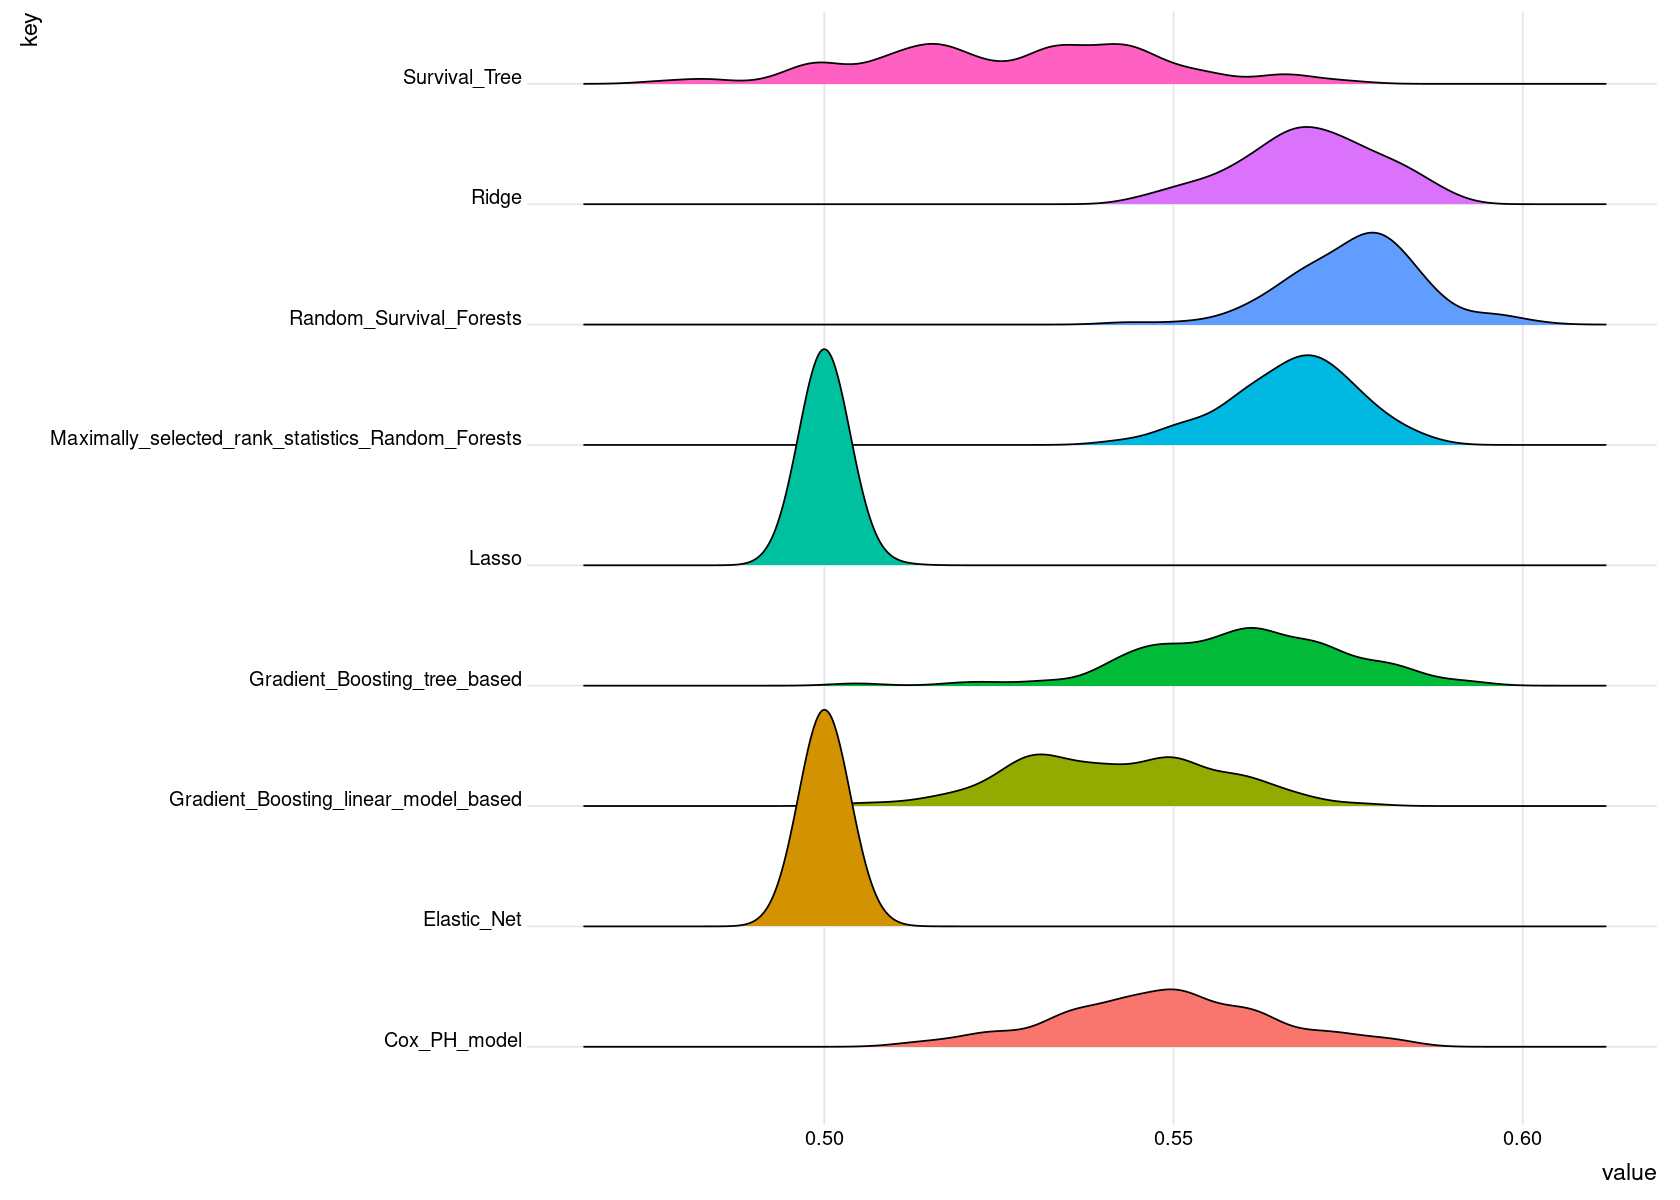

In [258]:
ggplot(c_df, aes(x = value, y = key, fill = key)) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none")

###  Random

In [326]:
type = "random"
df_names = names(dfs)

In [365]:
read_metalearners = function(type, df_names){
    mls = vector("list", length(df_names))
    for (i in 1:length(df_names)){
        filename = paste(data_path,"metalearners_",type,"_",df_names[[i]],".rds", sep="")
        print(filename)
        mls[[i]] = readRDS(filename)
    }
    mls
}

In [366]:
MLS = read_metalearners(type, df_names)

[1] "../data/metalearners_random_METABRIC.rds"
[1] "../data/metalearners_random_GSE11121.rds"
[1] "../data/metalearners_random_GSE96058.rds"
[1] "../data/metalearners_random_GSE7390.rds"
[1] "../data/metalearners_random_GSE9893.rds"
[1] "../data/metalearners_random_NKI.rds"


ERROR: Error in gzfile(file, "rb"): cannot open the connection


## Export code

In [13]:
system("python3 notebook2script.py 05_ml.ipynb")